Version: 4

Data: 2018 and combining the last 15 Resolution codes with the least count into one.  

Using SVM and TFID vectorizor

In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
#import requests
#from bs4 import BeautifulSoup
import re
import os
import sys
from IPython.display import display, HTML
import re
import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import regexp_tokenize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from keras.preprocessing import text, sequence

In [2]:
#load file
file_name = open('2_Case_Query_2018.csv', encoding="UTF-8", errors='ignore')
data=pd.read_csv(file_name)
data.shape

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(77839, 49)

In [3]:
#dropping unnecessary columns
data.drop(labels=['CaseClosedDate__c', 'CaseCreatedDate__c','CaseOwnerEmail__c',
                  'CaseOwnerProfile__c','Case_Age_In_Business_Hours__c', 'Case_Type__c', 
                  'ClosedDate','ContactEmail', 'CountryofIssue__c', 'CreatedDate', 
                  'CustomerRegion__c','Customer_Priority__c', 'DevtrackCreationDate__c',
                  'DevtrackId__c', 'Escalated_days__c', 'Escalated_to_Tier_4__c', 'Escalation_Severity__c',
                  'Infinera_Responsibility_HH_MM_SS__c','EnterDetailedProblemDescription__c',
       'Infinera_Responsibility_mins__c', 'LastActivityDate__c',
       'LastModifiedDate', 'Last_Status_Change__c', 'NetworkImpact__c',
       'NetworkStatus__c', 'Number_of_Hours_No_Action__c', 'Origin',
       'OutageStarttoOutageStopminutes__c','Resolution_Time__c', 'ResponseDate__c', 'ServiceAccount__c',
      'SpecificEscalationRequestQuestion__c','ProductId__c','ProductLine__c',
       'StarttoOutageStopmins_mins__c', 'Status', 'SWVersion__c','Severity__c',
       'TACCaseStatus__c', 'Tier_4_Escalation_Status__c','ResolutionDetails__c',
       'Time_With_Customer__c', 'Time_With_Support__c'], axis=1, inplace=True)
data.head(3)

,AccountId,CaseNumber,Description,Priority,ResolutionCode__c,Subject
0,0015000000MOCkCAAX,259654.0,CAUTION: This email originated from outside of...,Medium,Hardware Replaced,00259654 / Colt Telecom / Minor / Infinera RMA...
1,00138000016DWjAAAW,259737.0,CAUTION: This email originated from outside of...,Medium,Duplicate Case,00259737 / null / Minor / Re: Power under Volt...
2,0015000000f1vhLAAQ,258154.0,2x LIC-T-XT36-100Q-ZC8 required.,Standard,Instant Bandwidth Problem,00258154 / euNetworks Fiber UK Ltd / Minor / E...


# Extracting Key words and Preprocessing

In [4]:
#functions for pre-processing text
def cleanString(comment):
    #stopWords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(str(comment))
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) ]
                              #if w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list)
    
    return returnString#, idx_list

def give_last(string):        
    #last_string=[]
    last_string=str(string).split("/")
    last_string=" ".join(str(x) for x in last_string[-1:])
    return last_string

def remove_almum_and_digits(string): 
    pattern = '[0-9]'
    string = re.sub(pattern, ' ', string)
    # Remove some special characters
    string = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' ', str(string))
    # Replace numbers and symbols with language
    returnString = re.sub(r'([\;\:\|#*_=;.,\-\n])', ' ', string)
    return returnString


In [5]:
data['Key_words']=data['Subject'].apply(give_last)
data['Key_words']=data['Key_words'].apply(remove_almum_and_digits)
data['Key_words']=data['Key_words'].apply(cleanString)
data[['Subject','Key_words']].head()

,Subject,Key_words
0,00259654 / Colt Telecom / Minor / Infinera RMA...,infinera rma case number colt tt fan fail stl d d
1,00259737 / null / Minor / Re: Power under Volt...,re power under voltage and pem failure alarm x...
2,00258154 / euNetworks Fiber UK Ltd / Minor / E...,emergency license required for marseille frank...
3,00258310 / GCI / Informational / OA compatibility,oa compatibility
4,need to refurbish/ECO rework,eco rework


In [6]:
from rake_nltk import Rake
#extracting keyworkds from Subject and Description
def extract_key_words(string):
    r = Rake()
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    
    # extracting the words by passing the text
    r.extract_keywords_from_text(string)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    returnString=list(key_words_dict_scores.keys())
    returnString=" ".join(str(x) for x in returnString)
    return returnString

data['keys_with_nouns']=data['Key_words'].apply(extract_key_words)
data[['Key_words','keys_with_nouns']].head()

,Key_words,keys_with_nouns
0,infinera rma case number colt tt fan fail stl d d,fail rma tt stl number infinera case colt fan
1,re power under voltage and pem failure alarm x...,voltage xt mrwtn failure alarm pem power
2,emergency license required for marseille frank...,frankfurt license deployment marseille require...
3,oa compatibility,oa compatibility
4,eco rework,eco rework


In [7]:
words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(str(sent)) \
     if w.lower() in words or not w.isalpha())

data['keys_filtered']=data['keys_with_nouns'].apply(clean_sent)
data[['Key_words','keys_with_nouns','keys_filtered']].head()

,Key_words,keys_with_nouns,keys_filtered
0,infinera rma case number colt tt fan fail stl d d,fail rma tt stl number infinera case colt fan,fail number case colt fan
1,re power under voltage and pem failure alarm x...,voltage xt mrwtn failure alarm pem power,voltage failure alarm power
2,emergency license required for marseille frank...,frankfurt license deployment marseille require...,license deployment emergency
3,oa compatibility,oa compatibility,compatibility
4,eco rework,eco rework,rework


# Analysis of Resolution codes

In [27]:
print('Number of unique Resolution Code: ',len(data['ResolutionCode__c'].unique()))
codes=[]#list(data['ResolutionCode__c'].unique())
count_of_codes=[]
codes_grouped=data.groupby('ResolutionCode__c')
for code, count in codes_grouped: 
    codes.append(code)
    count_of_codes.append(len(count))
    
df=pd.DataFrame({
    'Resolution_code':codes,
    'Count':count_of_codes
})    
df.sort_values('Count', ascending = False)

Number of unique Resolution Code:  72


,Count,Resolution_code
30,5931,Hardware Replaced
29,2447,HW Failure- Routing to HW Services
12,1409,Configuration Error
49,1152,Operational Error
31,1097,Hardware Reset
20,1032,Duplicate Case
56,850,SW Fault - Correction Available
55,813,Question
23,763,External Fiber
69,745,Unknown - Unable to Reproduce


In [29]:
df.sort_values('Count', ascending = False,inplace=True)
df=df.tail(25)
print('Total number of rows clubbed: ',df['Count'].sum())
df

Total number of rows clubbed:  806


,Count,Resolution_code
70,73,Web Portal Problem
25,70,External Power
54,68,Product Improvement Request/Proposal
26,56,Failure on Customer Purchased Equipment
34,54,Infinera Maintenance
18,49,Documentation Error
19,47,Documentation Request
64,45,Software Request
10,43,Compatibility Issue
7,40,Change Request (Customization)


In [30]:
#list of Resolution codes that's going to be clubbed
less_frequent_codes=list(df['Resolution_code'])

#rename these Resolution codes in the original data as 'Less Frequent Codes'
for 

['Web Portal Problem',
 'External Power',
 'Product Improvement Request/Proposal',
 'Failure on Customer Purchased Equipment',
 'Infinera Maintenance',
 'Documentation Error',
 'Documentation Request',
 'Software Request',
 'Compatibility Issue',
 'Change Request (Customization)',
 'Capacity Exceeded',
 'Design Issue',
 '3rd Party Embedded/ Integrated Product - SW Failure',
 '3rd Party Embedded/ Integrated Product - HW Failure',
 'Multi-Vendor Support',
 'Error in MOP',
 'System Access Request',
 'Infinera Installation Error',
 'Customer Closure Request',
 'DNA TSV Import Issue',
 'Security Threat',
 '3rd Party Embedded/ Integrated Product - Documentation Error',
 'Infinera TAC Error',
 'UPS',
 'Open TOM']

In [ ]:
odd_codes=['Other','Question','Other Reason','Duplicate Case']
df[df['Resolution_code'].isin(odd_codes)]

In [12]:
data.ResolutionCode__c.value_counts().tail(23)

Product Improvement Request/Proposal                            68
Failure on Customer Purchased Equipment                         56
Infinera Maintenance                                            54
Documentation Error                                             49
Documentation Request                                           47
Software Request                                                45
Compatibility Issue                                             43
Capacity Exceeded                                               40
Change Request (Customization)                                  40
Design Issue                                                    39
3rd Party Embedded/ Integrated Product - SW Failure             35
3rd Party Embedded/ Integrated Product - HW Failure             30
Multi-Vendor Support                                            25
System Access Request                                           19
Error in MOP                                                  

In [21]:
print('Total Number of cases before filtering Duplicate cases: ',df['Count'].sum())

#Removing Duplicate Cases
data=data[data.ResolutionCode__c!='Duplicate Case']
data=data[data.ResolutionCode__c!='Other Reason']
data=data[data.ResolutionCode__c!='Other']
df=df[df.Resolution_code!='Duplicate Case']
df=df[df.Resolution_code!='Other Reason']
df=df[df.Resolution_code!='Other']

print('Total Number of cases after filtering Duplicate cases: ',df['Count'].sum())

Total Number of cases before filtering Duplicate cases:  41767
Total Number of cases after filtering Duplicate cases:  39878


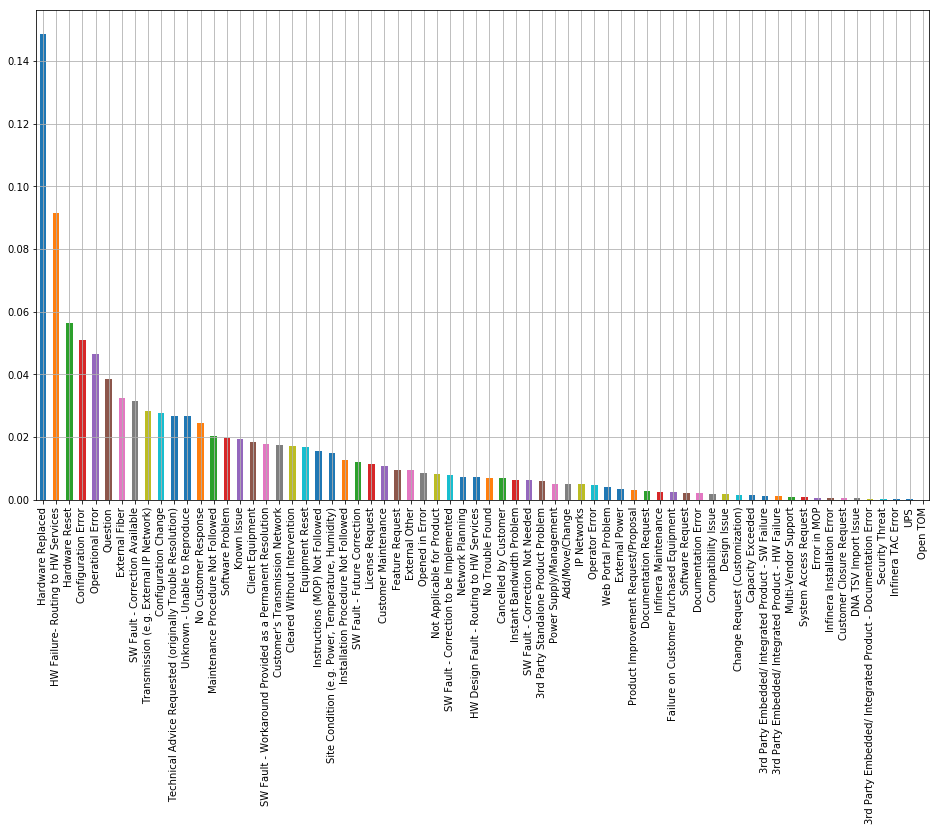

In [22]:
data.ResolutionCode__c.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

# Splitting the data

In [23]:
print('Number of unique Resolution Code: ',len(data['ResolutionCode__c'].unique()))
data['ResolutionCode__c'] = data['ResolutionCode__c'].astype(str)
labels = data['ResolutionCode__c']
text = data['keys_filtered']

X_train, X_test, y_train, y_test = train_test_split(text, labels, random_state=0, test_size=0.3)
X_train.head()

Number of unique Resolution Code:  69


83594    number item undeliverable serial line case
36075                                     id recall
23619                                            fa
15889                                       time pa
1104                                 new slot b mad
Name: keys_filtered, dtype: object

# Training with SVM

In [24]:
from sklearn.svm import LinearSVC
#import sklearn.calibration.CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder


In [25]:
svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 

In [26]:
model = Pipeline([('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clf)])

In [27]:
model.fit(X_train, y_train)

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...lty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='sigmoid'))])

In [28]:
model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...lty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='sigmoid'))])>

In [29]:
predictions = model.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
print('Testing accuracy %s' % accuracy_score(y_test, predictions))
print('Testing F1 score: {}'.format(f1_score(y_test, predictions, average='weighted')))

Testing accuracy 0.7517566428123581
Testing F1 score: 0.6727342875148015


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
predict=[" ERROR ON ROUTER SIDE"]
result = model.predict_proba(predict)*100
result

array([[5.70413961e-03, 2.91672175e-02, 2.48516235e-02, 4.02591759e-02,
        5.58781751e-02, 1.30885430e-01, 1.68722453e-02, 2.43048722e-02,
        2.79626655e-01, 5.45552281e-01, 2.77303722e-02, 1.28111061e+00,
        1.57848154e+00, 2.31197927e-02, 1.80997791e-01, 6.23833633e-01,
        1.62089768e-03, 4.21151239e-02, 5.41825645e-02, 4.44670264e-02,
        6.13564563e-01, 1.84072050e-02, 2.21973179e+00, 1.38227957e-01,
        3.60912068e-02, 5.17853602e-02, 3.02240892e-01, 1.13014422e-01,
        2.67510893e+00, 5.31562713e+00, 4.23052219e+00, 6.62733145e-02,
        2.91748275e-02, 2.21848772e-02, 4.51987255e-03, 4.66192684e-01,
        3.87379135e-02, 8.10521154e-01, 4.29220805e-01, 1.71357298e-02,
        2.69154716e-01, 1.08864173e-02, 4.55434264e-02, 3.28489729e-01,
        1.60823996e-01, 5.71645548e-02, 1.79752941e-03, 1.40041146e-01,
        1.91282840e+00, 8.96917778e-02, 5.54895351e-02, 3.99305702e-02,
        5.97668927e-01, 8.65728882e-01, 1.42429512e-01, 2.181080

In [75]:
data_pred = pd.DataFrame(columns=['Category', 'probability'])
data_pred['Category'] = model.classes_
data_pred['probability'] = pd.DataFrame((model.predict_proba(predict)*100).T, columns=['probability'])
data_pred=data_pred[data_pred.Category!='nan']
data_pred.sort_values('probability', ascending = False).head(5)

,Category,probability
29,Hardware Replaced,5.315627
30,Hardware Reset,4.230522
28,HW Failure- Routing to HW Services,2.675109
22,External Fiber,2.219732
48,Operational Error,1.912828


In [62]:
from sklearn.externals import joblib
filename = 'finalized_model_v2.sav'
joblib.dump(model, filename)

loaded_model = joblib.load(filename)

NameError: name 'joblib' is not defined

In [43]:
from sklearn.externals import joblib
joblib.dump(model, 'prediction_model.pkl')

['prediction_model.pkl']

In [22]:
model.predict_proba(predict)*100
print(metrics.classification_report(y_test,model.predict(X_test)))

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                                              precision    recall  f1-score   support

3rd Party Embedded/ Integrated Product - Documentation Error       0.00      0.00      0.00         1
         3rd Party Embedded/ Integrated Product - HW Failure       0.00      0.00      0.00         6
         3rd Party Embedded/ Integrated Product - SW Failure       0.00      0.00      0.00        11
                        3rd Party Standalone Product Problem       0.00      0.00      0.00        52
                                             Add/Move/Change       0.20      0.08      0.11        25
                                       Cancelled by Customer       0.00      0.00      0.00        56
                                           Capacity Exceeded       0.00      0.00      0.00         9
                              Change Request (Customization)       0.00      0.00      0.00        16
                                Cleared Without Intervention       0.00      0.00

# Testing out pickle files for UI

In [93]:
import gc
import pickle
file = open('prediction_model.pkl', 'rb')
gc.disable()
Mdl=pickle.load(file)

EOFError: 

# Other Models

In [81]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])
clf_2 = Pipeline([
    ('vect', HashingVectorizer(non_negative=True)),
    ('clf', MultinomialNB()),
])
clf_3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

svm = LinearSVC()
svm_clf = CalibratedClassifierCV(svm) 
clf_4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', svm_clf),
])
clf_5 = Pipeline([
    ('vect', HashingVectorizer(non_negative=True)),
    ('clf', svm_clf),
])
clf_6 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', svm_clf),
])
clfs = [clf_1, clf_2, clf_3,clf_4, clf_5, clf_6]
clf_names=['Naive Bayes with CountVectorizor','Naive Bayes with HashingVectorizer','Naive Bayes with TfidVectorizor',
           'SVM with CountVectorizor','SVM with HashingVectorizer','SVM with TfidVectorizor',]

In [82]:
from sklearn.model_selection  import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold( n_splits=K,random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print (np.mean(scores), sem(scores))

In [84]:
i=0
for clf in clfs:
    print(clf_names[i])
    evaluate_cross_validation(clf, data['keys_filtered'],data['ResolutionCode__c'], 5)
    print('-'*20)
    i=i+1

Naive Bayes with CountVectorizor
[0.57668272 0.63657076 0.42178244 0.65288718 0.64859059]
0.5873027374066452 0.043585899447750695
--------------------
Naive Bayes with HashingVectorizer


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in versi

[0.71468559 0.63103763 0.37139509 0.73276479 0.74363648]
0.6387039161094574 0.0696937179049779
--------------------
Naive Bayes with TfidVectorizor
[0.68812655 0.64627002 0.38584728 0.71779181 0.72313   ]
0.6322331307003066 0.06309105602793266
--------------------
SVM with CountVectorizor


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warnin

[0.70654863 0.65277959 0.39007877 0.73224399 0.74090229]
0.6445106525849559 0.06543743346356069
--------------------
SVM with HashingVectorizer


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too fe

[0.70602786 0.6555787  0.38825597 0.7305514  0.74194388]
0.6444715629638481 0.06575316189269131
--------------------
SVM with TfidVectorizor


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warnin

[0.70479104 0.65505794 0.38727947 0.7302259  0.73973049]
0.6434169670076428 0.06569657104147919
--------------------
